In [8]:
import pandas as pd
import numpy as np 

import timeit
import random 

import pickle
from matplotlib import pyplot as plt

import keras
from keras.datasets import cifar10
from keras import preprocessing
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD, Adam
from keras import regularizers
# random.seed(666)
# np.random.seed(666)
# import tensorflow as tf
# tf.random.set_seed(666)

## Loading and Preprocessing dataset.

In [9]:
class Data_gen:
    """
        Data_gen class loads the CIFAR10 dataset and performs preprocessing.
    
    """
    
    def __init__(self):
        """
        Method for initializing a Data_gen object.
        """
        pass

    def load_dataset(self,dataset_name):
        """
        Loads the cifar10 dataset from keras api.
        
        Args: 
            dataset_name(obj)
        
        Attributes:
            dataset_name(obj): Name of the data set (cifar10)
            
        Returns: 
            Loaded dataset:
            X_train
            Y_train
            X_test
            Y_test
        """
        
        self.dataset_name=dataset_name
        
        (X_train,Y_train),(X_test,Y_test)=self.dataset_name.load_data()       # Loading data from keras: cifar10 
        

        # Dataset exploration
        
        print("X_train: ",X_train.shape)    
        print("Y_train: ",Y_train.shape)
        print("X_test: ",X_test.shape)
        print("Y_test: ",Y_test.shape)

        print("Distinct labels:", np.unique(Y_train))

        
        #Showing the images. 
        
        for i in range(9):
            plt.subplot(330 + 1 + i)
            plt.imshow(X_train[i])
        plt.show()

        return X_train,Y_train,X_test,Y_test
    
    def preprocess(self,splits,sample_train,sample_percentage):
        """
            Performs the preprocessing steps for the dataset. Splits the dataset into 20% (10000) values out of (50000) for training.
            
            Args:
                
                splits (Tuple)
                sample_train (Bool)
                sample_percentage (Float)
            
            Atributes:
            
                splits (Tuple): A tuple of data(numpy arrays) returned by method "load_dataset"
                sample_train (Bool): A boolean to sample the (50000) training data X_train into (10000) X_train. {Preset to True}.
                sample_percentage (Float): preset percentage of 20% as per the task.
                
            Returns: 
                 X_train_normalized (numpy array): Shape => (10000,32,32,3) , Preprocessed 10000 randomly sampled samples for training
                 Y_train (numpy array): Shape => (10000,), 10000 randomly sampled categorical labels for training.
                 X_test_normalized (numpy array): Shape => (10000,32,32,3), Preprocessed test set.
                 Y_test (numpy array): Shape => (10000,) 10000 randomly sampled categorical labels for training.
        
        """
        self.splits=splits
        self.sample_train=sample_train
        self.sample_percentage=sample_percentage
        
        X_train,Y_train,X_test,Y_test=self.splits           #unpacking tuple

        # Preprocessing
        
        Y_train=to_categorical(Y_train)                     #50000  Converting into categorical values/one hot encoded
        Y_test=to_categorical(Y_test)                       #10000

       

        X_train_normalized=X_train.astype('float32')        # converting unsigned into float
        X_test_normalized=X_test.astype('float32')
        X_train_normalized=X_train_normalized/255.0         #50000 . Normalizing the data to be in between 0 and 1 by diving with the max value.
        X_test_normalized=X_test_normalized/255.0           #10000

        
        if self.sample_train:                               # sampling for required percentage of data for training..
            
            sample_size=int((self.sample_percentage)*(len(X_train_normalized)))    # creates a sample size.
            
            idx=np.random.choice(np.arange(len(X_train_normalized)),
                                 sample_size,replace=False) # generates a 1-D numpy array with randomized indexes.
    #         print(len(set(idx.tolist())))

            X_train_normalized=X_train_normalized[idx]      #10000 Fetching 20% randomized data as per indexing done.
            Y_train=Y_train[idx]                            #10000 Fetching the same indexed target labels.
        # creating validation set out of test set..
        
        real_test_indexes=np.arange(len(X_test_normalized))
        idx_val=set(np.random.choice(real_test_indexes,int(len(X_test_normalized)/2),replace=False).tolist())
        idx_test=set(real_test_indexes.tolist())-idx_val
        
        print("set intersection")
        print(idx_val.intersection(idx_test))
        print(np.asarray(list(idx_val)).shape)
        X_val_normalized=X_test_normalized[np.asarray(list(idx_val))]
        Y_val=Y_test[np.asarray(list(idx_val))]
        
        X_test_normalized=X_test_normalized[np.asarray(list(idx_test))]
        Y_test=Y_test[np.asarray(list(idx_test))]
        
        return X_train_normalized,Y_train,X_test_normalized,Y_test,X_val_normalized,Y_val

## Creating 3 Models:
- MLP
- CNN-1
- CNN-2 

In [10]:
class Models:
    """
    This class contains 3 Architectures.
    MLP: Multilayer perceptron Architecture with conditional statements to modify the architecture.
    CNN-1: Architecture with No Dropouts. 
    CNN-2: Architecture with Dropouts.    
    """
    def __init__(self,X_train_normalized):
        """Method for initializing MOdels object.
        
        Args:
            X_train_normalized (numpy array)
            
        Atributes:
            X_train_normalized (numpy array): Train set to feed the input shape for the Architectures
        """
        
        self.X_train_normalized=X_train_normalized
    
    def MLP(self,neurons,add_d3,add_d4): 
        
        """ Multi layer perceptron with 2 Dense/Hidden Layers and 1 output layer. Neurons: 512, Activation: sigmoid in H.L. Softmax at output
            layer with 10 neurons.
            
            Args:
                neurons (int)
                add_d3 (Bool)
                add_d4 (Bool)
            
            
            Attributes:
                neurons (int): Number of neurons in the dense layer.
                add_d3 (Bool): Boolean to add an additional(3rd) dense layer.
                add_d4 (Bool): Boolean to add an additional(4th) dense layer.
                
            Returns:
                model: Compiled model with the given architecture.
        
        """
        self.neurons=neurons
        self.add_d3=add_d3
        self.add_d4=add_d4
        
        model = Sequential()             # Sequential keras Model
        
        model.add(Flatten())             # Flattening the imput layer to pass through the dense layer.=> (None, 32,32,3)=> (3072)
        
        model.add(Dense(self.neurons))   # A Fully connected dense layer. Takes neurons as 512 in our case. Params: 1573376
        model.add(Activation('sigmoid')) # sigmoid as activation function. maps values between 0 and 1. 
      
        model.add(Dense(self.neurons))   # Another Fully connected layer
        model.add(Activation('sigmoid')) # Sigmoid as Activation function.
        
        if self.add_d3:                  # To modify the architecture, and add an another dense layer. (3rd)
            
            model.add(Dense(self.neurons))
            model.add(Activation('sigmoid'))
        
        if self.add_d3:                  # To modify the architecture, and add an another dense layer. (4th)
            
            model.add(Dense(self.neurons))
            model.add(Activation('sigmoid'))
        
        model.add(Dense(10))             # Fully connected layer with 10 classes as output layer.
        model.add(Activation('softmax')) # Softmax function to convert arbitary resulted real values into probabilities.

        model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) # Initializes the optimizer and loss function for training.
        
        return model
    
    def CNN1(self,neurons): 
        
        """ Convolutional Neural Network with 2 Con2D Layers, 2 Dense Layers and 1 output layer. 
            Neurons: 512, Activation: sigmoid in H.L. Softmax at output layer with 10 neurons.
            
            Args:
            
                neurons (int)
            
            Attributes:
            
                neurons (int): Number of neurons in the dense layer.
            
            Returns:
                model: Compiled CNN model with the given architecture.
        """
        self.neurons=neurons
        
        model= Sequential() # Seq model keras.
        
        model.add(Conv2D(64, (3,3), padding='same', input_shape=     # Conv layer with 64 filters, filter shape=(3,3,3), input shape => (B.S,32,32,3) 
                         self.X_train_normalized.shape[1:])) 
        model.add(Activation('relu'))                                # Relu as activation.
        
        model.add(Conv2D(64,(3, 3),padding='same'))                                 # Con layer with 64 filters, filter shape=(3,3,64), input shape=> (B.s,32,32,64)
        model.add(Activation('relu'))
        
        model.add(Flatten())   # Flattening the input before dense layer.
        
        model.add(Dense(self.neurons))                               # Dense/Fully connected layer with 512 neurons
        model.add(Activation('sigmoid'))                             # SGD as activation function.
        
        model.add(Dense(self.neurons))                               # 2nd Dense layer with same number of neurons i.e. 512.        
        model.add(Activation('sigmoid'))                             # SGD maps the result b/1 0 and 1.
        
        model.add(Dense(10))                                         # Output layer with 10 neurons for 10 classes 
        
        model.add(Activation('softmax'))                             # softmax to output the probs.

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Initializes the optimizer and loss function for training.
        return model
    
    def CNN2(self,neurons):
        
        """ Convolutional Neural Network with 2 Con2D Layers, 2 Dense Layers, 2 MaxPool2D, 2 Dropouts and 1 output layer. 
            Neurons: 512, Activation: sigmoid in H.L. Softmax at output layer with 10 neurons.
            
            Args:
            
                neurons (int)
            
            Attributes:
            
                neurons (int): Number of neurons in the dense layer.
            
            Returns:
                model: Compiled CNN model with the given architecture.
        """
        
        self.neurons=neurons
        
        model=Sequential()
        
        model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same',activation='relu',
                         input_shape=self.X_train_normalized.shape[1:]))                    # Conv layer with 64 filters, filter shape=(3,3,3), input shape => (B.S,32,32,3) 
        model.add(MaxPooling2D(pool_size=(2,2)))                                            # Max pooling with a filter of (2,2) for capturing important features.

        model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='relu'))  # Conv layer with 64 filters, filter shape=(3,3,64), input shape => (B.S,32,32,3)         
        model.add(MaxPooling2D(pool_size=(2,2)))                   # Max pooling with a filter of (2,2) for capturing important features.
        
        model.add(Flatten())                                       # Flattening before the dense layer
        model.add(Dense(self.neurons,activation='sigmoid'))        # Fully connected layer with 512 neurons and sigmoid as activation.
        model.add(Dropout(0.2))                                    # Dropout of 0.2 to prevent overfitting.

        model.add(Dense(self.neurons,activation='sigmoid'))
        model.add(Dropout(0.2))                                    # Dropout of 0.2 to prevent overfitting after 2nd dense layer.
        
        model.add(Dense(10, activation='softmax'))                 # Dense layer with 10 neurons as output layer.
        
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # Initializes the optimizer and loss function for training.
        return model 

## Creating basic plots for 3 Networks

- Training Accuracy vs Validation accuracy
- Training Loss vs Validation Loss

In [11]:
class Plots:
    """Plots for training and testing process: loss and accuracy
    """ 
    def __init__(self,model):
        """
        Args:
            model (obj)
            
        Attributes: 
            model (obj): Trained model to get the accuracy and loss for training and validation for plots using history object.
            
        """
        self.model=model
        
    def accuracy(self):
        """
        plots the Training Accuracy vs Validation Accuracy
        """
        
        self.accuracy=self.model.history['accuracy']          #Get traning accuracy from model.history
        self.val_accuracy=self.model.history['val_accuracy']  #Get val accuracy from model.history
        
        plt.figure(figsize=(8,7))

        plt.plot(self.accuracy,'b')
        plt.plot(self.val_accuracy,'g')
        plt.xticks(np.arange(1,6,1))
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy vs Validation Accuracy")
        plt.legend(['Training Accuracy','Validation Accuracy'])
        plt.show()
#         plt.savefig("acc.png")
    
    def loss(self):
        """
        plots the Training Loss vs Validation Loss
        """
        self.loss=self.model.history['loss']                    #Get traning loss from model.history
        self.val_loss=self.model.history['val_loss']            #Get val loss from model.history
        
        plt.figure(figsize=(8,7))

        plt.plot(self.loss,'b')
        plt.plot(self.val_loss,'g')
        plt.xticks(np.arange(1,6,1))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Validation Loss")
        plt.legend(['Training Loss','Validation Loss'])
        plt.show()
#         plt.savefig("loss.png")

X_train:  (50000, 32, 32, 3)
Y_train:  (50000, 1)
X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)
Distinct labels: [0 1 2 3 4 5 6 7 8 9]


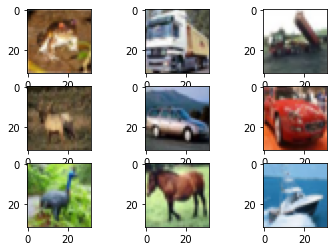

set intersection
set()
(5000,)


In [12]:
# if __name__=='__main__':
    
#Creating instance of Data_gen and calling methods of Data_gen class.
cf=Data_gen()
splits=cf.load_dataset(cifar10)
data=cf.preprocess(splits,sample_train=True,sample_percentage=0.2)
X_train_normalized,Y_train,X_test_normalized,Y_test,X_val_normalized,Y_val=data

In [13]:
print(X_train_normalized.shape)
print(X_test_normalized.shape)
print(X_val_normalized.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

(10000, 32, 32, 3)
(5000, 32, 32, 3)
(5000, 32, 32, 3)
(10000, 10)
(5000, 10)
(5000, 10)


----------------------------------
# MLP
---------------------------------

In [14]:
#Creating instance of Models for MLP

mlp_ob=Models(X_train_normalized)

"""
MLP-------------------------------
"""

start_mlp=timeit.default_timer()
print("MLP(512,add_d3=False,add_d4=False)")

"""
Call base MLP: Neurons 512 | Layers 2 Dense
"""
mlp_base=mlp_ob.MLP(512,add_d3=False,add_d4=False) 
mlp_base_h=mlp_base.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

stop_mlp=timeit.default_timer()



print("MLP(1024,add_d3=False,add_d4=False)")
"""
Call MLP: Neurons 1024 | Layers 2 Dense
"""

mlp1=mlp_ob.MLP(1024,add_d3=False,add_d4=False) 
mlp1_h=mlp1.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))


print("MLP(2048,add_d3=False,add_d4=False)")
"""
Call MLP: Neurons 2048 | Layers 2 Dense
"""

mlp2=mlp_ob.MLP(2048,add_d3=False,add_d4=False) 
mlp2_h=mlp2.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

print("MLP(512,add_d3=True,add_d4=False)")

"""
Call base MLP: Neurons 512 | Layers 3 Dense
"""
mlp3=mlp_ob.MLP(512,add_d3=True,add_d4=False) 
mlp3_h=mlp3.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

print("MLP(1024,add_d3=True,add_d4=False)")

"""
Call MLP: Neurons 1024 | Layers 3 Dense
"""

mlp4=mlp_ob.MLP(1024,add_d3=True,add_d4=False) 
mlp4_h=mlp4.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

print("MLP(2048,add_d3=True,add_d4=False)")
"""
Call MLP: Neurons 2048 | Layers 3 Dense
"""

mlp5=mlp_ob.MLP(2048,add_d3=True,add_d4=False) 
mlp5_h=mlp5.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))


print("MLP(512,add_d3=True,add_d4=True)")

"""
Call base MLP: Neurons 512 | Layers 4 Dense
"""
mlp6=mlp_ob.MLP(512,add_d3=True,add_d4=True) 
mlp6_h=mlp6.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

print("MLP(1024,add_d3=True,add_d4=True)")

"""
Call MLP: Neurons 1024 | Layers 4 Dense
"""

mlp7=mlp_ob.MLP(1024,add_d3=True,add_d4=True) 
mlp7_h=mlp7.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

print("MLP(2048,add_d3=True,add_d4=True)")
"""
Call MLP: Neurons 2048 | Layers 4 Dense
"""

mlp8=mlp_ob.MLP(2048,add_d3=True,add_d4=True) 
mlp8_h=mlp8.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))


MLP(512,add_d3=False,add_d4=False)
Epoch 1/5
313/313 [==============================] - 1s 4ms/step - loss: 2.0623 - accuracy: 0.2471 - val_loss: 1.9480 - val_accuracy: 0.2866
Epoch 2/5
313/313 [==============================] - 1s 4ms/step - loss: 1.8896 - accuracy: 0.3112 - val_loss: 1.8939 - val_accuracy: 0.3144
Epoch 3/5
313/313 [==============================] - 1s 4ms/step - loss: 1.8193 - accuracy: 0.3436 - val_loss: 1.8319 - val_accuracy: 0.3314
Epoch 4/5
313/313 [==============================] - 1s 4ms/step - loss: 1.7819 - accuracy: 0.3523 - val_loss: 1.8433 - val_accuracy: 0.3164
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 1.7421 - accuracy: 0.3725 - val_loss: 1.8316 - val_accuracy: 0.3406
MLP(1024,add_d3=False,add_d4=False)
Epoch 1/5
313/313 [==============================] - 2s 5ms/step - loss: 2.0854 - accuracy: 0.2342 - val_loss: 2.0068 - val_accuracy: 0.2610
Epoch 2/5
313/313 [==============================] - 1s 4ms/step - loss: 1.9024 - a

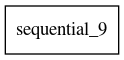

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(mlp_base, to_file='mlp_base.png', show_shapes=True, show_layer_names=True)

------------------------------------------
## CNN-1
------------------------------------------

In [16]:
print("CNN-1")

# creating an instance of Models class for CNN-1

cnn1_ob=Models(X_train_normalized)
"""
CNN-1 ---------------------------------------
"""
start_cnn1=timeit.default_timer()

cnn1=cnn1_ob.CNN1(512)
cnn1_h=cnn1.fit(X_train_normalized, Y_train, batch_size=32, epochs=5, validation_data=(X_val_normalized,Y_val))

stop_cnn1=timeit.default_timer()

CNN-1
Epoch 1/5
313/313 [==============================] - 3s 11ms/step - loss: 1.8174 - accuracy: 0.3341 - val_loss: 1.5646 - val_accuracy: 0.4244
Epoch 2/5
313/313 [==============================] - 3s 10ms/step - loss: 1.3906 - accuracy: 0.4972 - val_loss: 1.4603 - val_accuracy: 0.4562
Epoch 3/5
313/313 [==============================] - 3s 10ms/step - loss: 1.0875 - accuracy: 0.6119 - val_loss: 1.3558 - val_accuracy: 0.5252
Epoch 4/5
313/313 [==============================] - 3s 10ms/step - loss: 0.7248 - accuracy: 0.7534 - val_loss: 1.4317 - val_accuracy: 0.5212
Epoch 5/5
313/313 [==============================] - 3s 10ms/step - loss: 0.3625 - accuracy: 0.8872 - val_loss: 1.6949 - val_accuracy: 0.5192


In [17]:
cnn1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_78 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_79 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_78 (Dense)             (None, 512)               33554944  
_________________________________________________________________
activation_80 (Activation)   (None, 512)             

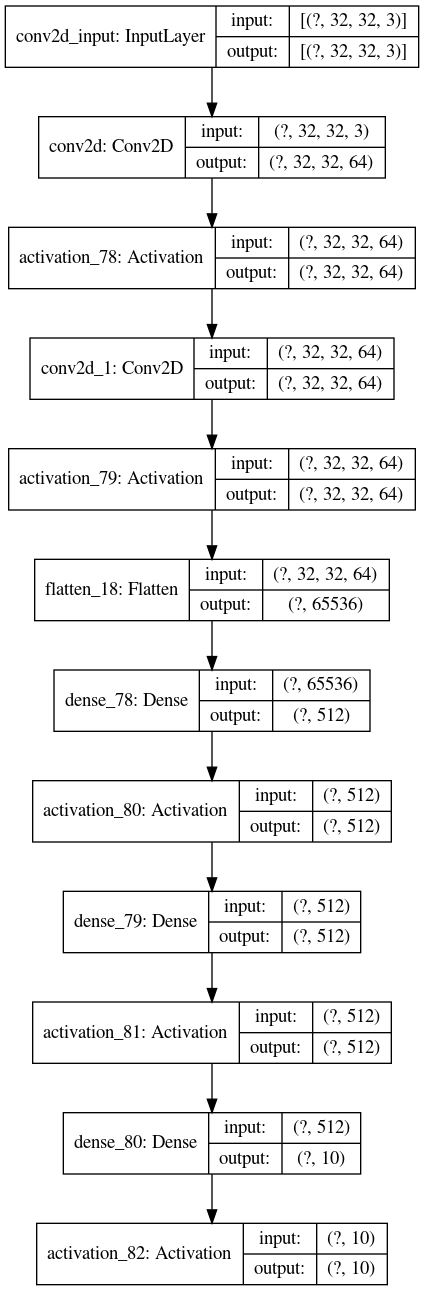

In [18]:
plot_model(cnn1, to_file='cnn1.png', show_shapes=True, show_layer_names=True)

---------------------------------------------
## CNN-2
---------------------------------------------

In [19]:
# creating an instance of Models for CNN-2

print("CNN-2")

cnn2_ob=Models(X_train_normalized)

"""
CNN-2
"""
start_cnn2=timeit.default_timer()

cnn2=cnn2_ob.CNN2(512)
cnn2_h=cnn2.fit(X_train_normalized,Y_train,batch_size=32,epochs=5,validation_data=(X_val_normalized,Y_val))

stop_cnn2=timeit.default_timer()

CNN-2
Epoch 1/5
313/313 [==============================] - 2s 6ms/step - loss: 1.9362 - accuracy: 0.2760 - val_loss: 1.6099 - val_accuracy: 0.4078
Epoch 2/5
313/313 [==============================] - 2s 5ms/step - loss: 1.4953 - accuracy: 0.4579 - val_loss: 1.4037 - val_accuracy: 0.4794
Epoch 3/5
313/313 [==============================] - 2s 5ms/step - loss: 1.3072 - accuracy: 0.5272 - val_loss: 1.2942 - val_accuracy: 0.5274
Epoch 4/5
313/313 [==============================] - 2s 5ms/step - loss: 1.1524 - accuracy: 0.5874 - val_loss: 1.2040 - val_accuracy: 0.5634
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 1.0162 - accuracy: 0.6398 - val_loss: 1.2141 - val_accuracy: 0.5712


In [20]:
cnn2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 512)               2097664   
_________________________________________________________________
dropout (Dropout)            (None, 512)             

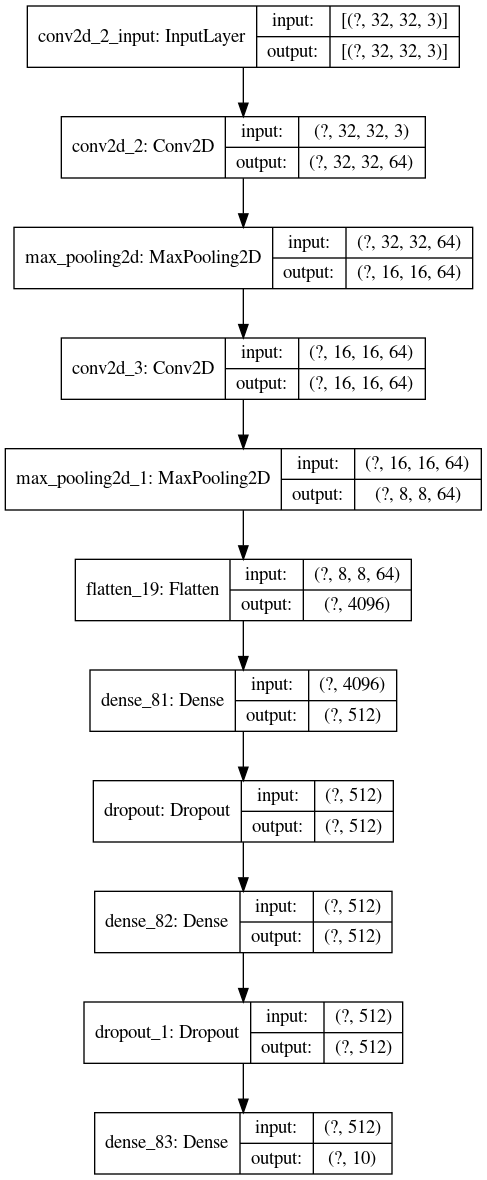

In [21]:
plot_model(cnn2, to_file='cnn2.png', show_shapes=True, show_layer_names=True)

--------------------
## Reporting the Testing accuracies..
-----------------------

### Testing accuracy | MLP

In [22]:
loss,acc=mlp_base.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for MLP at base/given architecture: ",acc*100)

157/157 [==============================] - 0s 2ms/step - loss: 1.8107 - accuracy: 0.3542
Testing Accuracy for MLP at base/given architecture:  35.4200005531311


### Testing accuracy | CNN-1

In [23]:
loss_c1,acc_c1=cnn1.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for CNN-1: ",acc_c1*100)

157/157 [==============================] - 1s 4ms/step - loss: 1.6791 - accuracy: 0.5304
Testing Accuracy for CNN-1:  53.039997816085815


### Testing accuracy | CNN-2

In [24]:
loss_c2,acc_c2=cnn2.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for CNN-2: ",acc_c2*100)

157/157 [==============================] - 0s 3ms/step - loss: 1.2100 - accuracy: 0.5738
Testing Accuracy for CNN-2:  57.38000273704529


------------------------------
## Time Analysis:
--------------------------------

In [25]:
cnn1_t=stop_cnn1-start_cnn1
cnn2_t=stop_cnn2-start_cnn2
print("Time taken by Base MLP:", stop_mlp-start_mlp)
print("Time taken by CNN-1: ",stop_cnn1-start_cnn1)
print("Time taken by CNN-2: ",stop_cnn2-start_cnn2)
pd.concat([pd.DataFrame({"Model":["CNN-1","CNN-2"]}),pd.DataFrame({"Time Taken":[cnn1_t,cnn2_t]})],axis=1)

Time taken by Base MLP: 7.111129791999701
Time taken by CNN-1:  19.07551037199937
Time taken by CNN-2:  9.673361764999754


,Model,Time Taken
0,CNN-1,19.075510
1,CNN-2,9.673362


------------------------
## Plots
-------------------------

MLP Plots for Training and validation | Accuracy and Loss


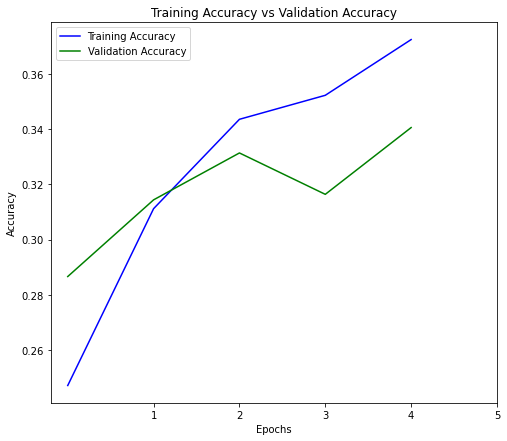

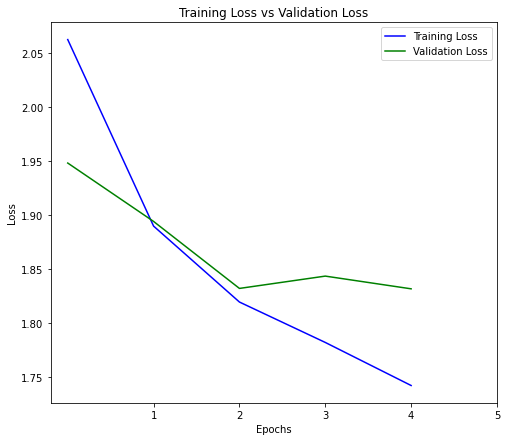

In [26]:
"""
MLP Plot for Training and validation
"""
print("MLP Plots for Training and validation | Accuracy and Loss")
mlp=Plots(mlp_base_h)
mlp.accuracy()
mlp.loss()

______________
### CNN- 1 Plots for Training and validation 
_________________

CNN- 1 Plots for Training and validation | Accuracy and Loss


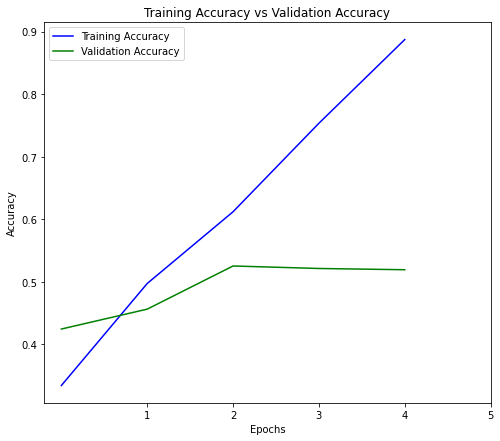

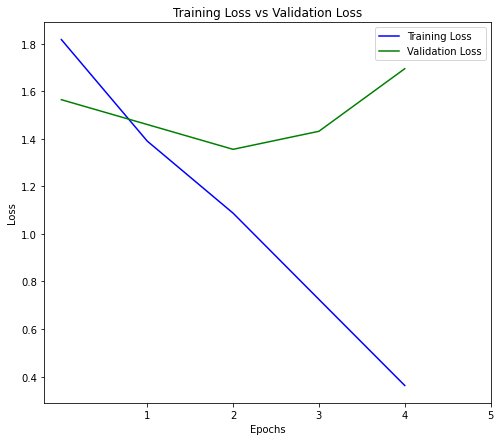

In [27]:

"""
CNN- 1 Plots for Training and validation 
"""
print("CNN- 1 Plots for Training and validation | Accuracy and Loss")
cnn1plot=Plots(cnn1_h)
cnn1plot.accuracy()
cnn1plot.loss()

________________________________
### CNN- 2 Plots for Training and validation 
__________________________________

CNN- 2 Plots for Training and validation | Accuracy and Loss


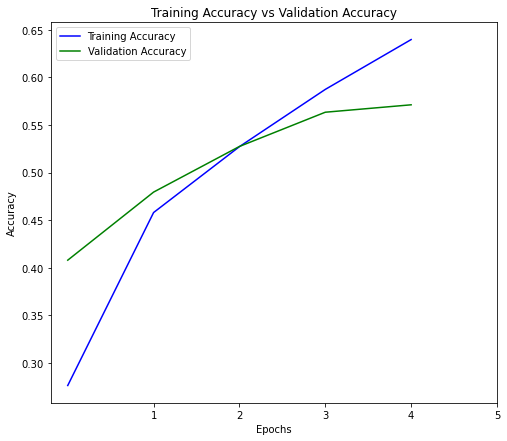

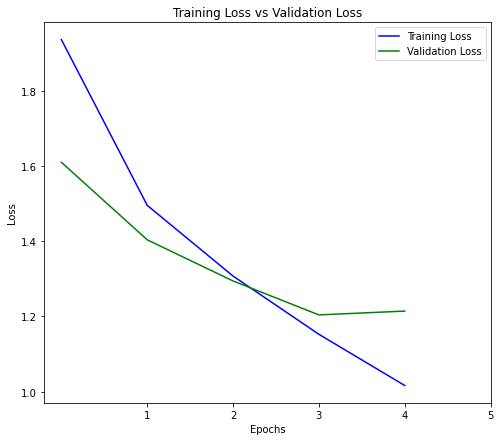

In [28]:
"""
CNN- 1 Plots for Training and validation 
"""
print("CNN- 2 Plots for Training and validation | Accuracy and Loss")

cnn2plot=Plots(cnn2_h)
cnn2plot.accuracy()
cnn2plot.loss()

## MLP PLots for Report for different architectures

In [29]:
names=pd.DataFrame({"Model Name":["MLP_base","MLP 1","MLP 2","MLP 3","MLP 4","MLP 5","MLP 6","MLP 7","MLP 8"]})
desc=pd.DataFrame({"Description":["2 H.L/Dense | 512 neurons","2 H.L/Dense | 1024 neurons","2 H.L/Dense | 2048 neurons"
                  ,"3 H.L/Dense | 512 neurons","3 H.L/Dense | 1024 neurons","3 H.L/Dense | 2048 neurons"
                                       ,"4 H.L/Dense | 512 neurons","4 H.L/Dense | 1024 neurons","4 H.L/Dense | 2048 neurons"]})
MLP_models=pd.concat([names,desc],axis=1)

In [30]:
MLP_models

,Model Name,Description
0,MLP_base,2 H.L/Dense | 512 neurons
1,MLP 1,2 H.L/Dense | 1024 neurons
2,MLP 2,2 H.L/Dense | 2048 neurons
3,MLP 3,3 H.L/Dense | 512 neurons
4,MLP 4,3 H.L/Dense | 1024 neurons
5,MLP 5,3 H.L/Dense | 2048 neurons
6,MLP 6,4 H.L/Dense | 512 neurons
7,MLP 7,4 H.L/Dense | 1024 neurons
8,MLP 8,4 H.L/Dense | 2048 neurons


In [31]:
def mlp_variants(acc_type):
    # mlp plots for different models
    # Training accuracy diff mlp models
    
    plt.figure(figsize=(10,7))
    plt.plot(mlp_base_h.history[acc_type])
    plt.plot(mlp1_h.history[acc_type])
    plt.plot(mlp2_h.history[acc_type])
    plt.plot(mlp3_h.history[acc_type])
    plt.plot(mlp4_h.history[acc_type])
    plt.plot(mlp5_h.history[acc_type])
    plt.plot(mlp6_h.history[acc_type])
    plt.plot(mlp7_h.history[acc_type])
    plt.plot(mlp8_h.history[acc_type])
    plt.xticks([0,1,2,3,4])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["MLP_base","MLP 1","MLP 2","MLP 3","MLP 4","MLP 5","MLP 6","MLP 7","MLP 8"])
    if acc_type=='accuracy':
        plt.title("Training Accuracy for different MLP models")
    else:
        plt.title("Validation Accuracy for different MLP models")
    plt.show()

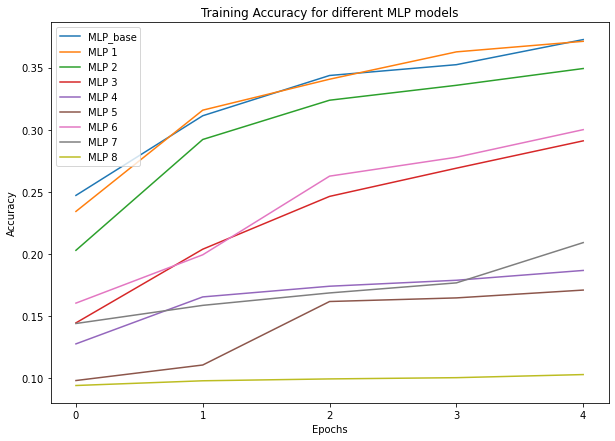

In [32]:
# Training accuracy for different mlp models
mlp_variants('accuracy')

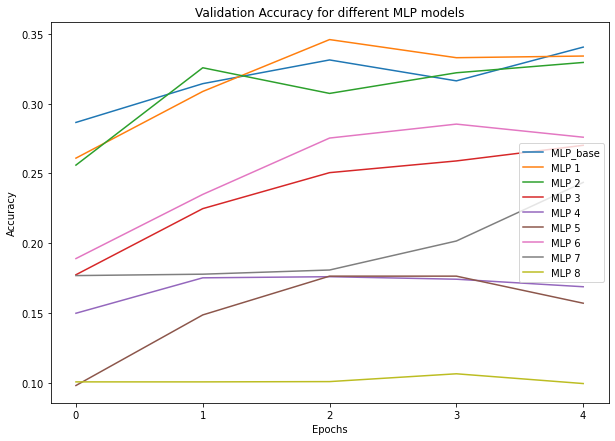

In [33]:
# Validation accuracy for different mlp models
mlp_variants('val_accuracy')

<!-- ## Results analysis using confusion matrix and plots -->

In [34]:
# y_pred=np.argmax(mlp_base.predict(X_test_normalized),axis=1)

# Experimenting with more number of epochs

### MLP

In [35]:

"""
MLP-------------------------------
"""

start_mlp=timeit.default_timer()
print("MLP(512,add_d3=False,add_d4=False) epochs=20" )

"""
Call base MLP: Neurons 512 | Layers 2 Dense
"""
mlp_base=mlp_ob.MLP(512,add_d3=False,add_d4=False) 
mlp_base_h=mlp_base.fit(X_train_normalized, Y_train, batch_size=32, epochs=20, validation_data=(X_val_normalized,Y_val))

stop_mlp=timeit.default_timer()

MLP(512,add_d3=False,add_d4=False) epochs=20
Epoch 1/20
313/313 [==============================] - 1s 4ms/step - loss: 2.0713 - accuracy: 0.2388 - val_loss: 1.9745 - val_accuracy: 0.2858
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 1.9064 - accuracy: 0.3137 - val_loss: 1.8476 - val_accuracy: 0.3414
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 1.8326 - accuracy: 0.3424 - val_loss: 1.8484 - val_accuracy: 0.3310
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 1.7881 - accuracy: 0.3599 - val_loss: 1.8285 - val_accuracy: 0.3232
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 1.7515 - accuracy: 0.3693 - val_loss: 1.8035 - val_accuracy: 0.3474
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 1.7238 - accuracy: 0.3820 - val_loss: 1.8253 - val_accuracy: 0.3464
Epoch 7/20
313/313 [==============================] - 1s 5ms/step - loss: 1.7084 - accuracy: 0.3944 - v

In [36]:
loss,acc=mlp_base.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for MLP at base/given architecture at 20 epochs: ",acc*100)

157/157 [==============================] - 0s 2ms/step - loss: 1.6543 - accuracy: 0.4138
Testing Accuracy for MLP at base/given architecture at 20 epochs:  41.38000011444092


In [37]:
print("CNN-1-20 epochs")

# creating an instance of Models class for CNN-1

"""
CNN-1 ---------------------------------------
"""
start_cnn1=timeit.default_timer()

cnn1=cnn1_ob.CNN1(512)
cnn1_h=cnn1.fit(X_train_normalized, Y_train, batch_size=32, epochs=20, validation_data=(X_val_normalized,Y_val))

stop_cnn1=timeit.default_timer()

CNN-1-20 epochs
Epoch 1/20
313/313 [==============================] - 3s 11ms/step - loss: 1.7311 - accuracy: 0.3692 - val_loss: 1.5647 - val_accuracy: 0.4430
Epoch 2/20
313/313 [==============================] - 3s 11ms/step - loss: 1.2955 - accuracy: 0.5383 - val_loss: 1.3726 - val_accuracy: 0.5064
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 0.9847 - accuracy: 0.6516 - val_loss: 1.3229 - val_accuracy: 0.5396
Epoch 4/20
313/313 [==============================] - 3s 10ms/step - loss: 0.6042 - accuracy: 0.7959 - val_loss: 1.4071 - val_accuracy: 0.5440
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 0.2708 - accuracy: 0.9224 - val_loss: 1.5626 - val_accuracy: 0.5458
Epoch 6/20
313/313 [==============================] - 3s 10ms/step - loss: 0.0849 - accuracy: 0.9806 - val_loss: 1.7199 - val_accuracy: 0.5468
Epoch 7/20
313/313 [==============================] - 3s 9ms/step - loss: 0.0302 - accuracy: 0.9945 - val_loss: 1.8878 - val_a

In [38]:
loss_c1,acc_c1=cnn1.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for CNN-1 at 20 epochs: ",acc_c1*100)

157/157 [==============================] - 1s 3ms/step - loss: 2.2713 - accuracy: 0.5704
Testing Accuracy for CNN-1 at 20 epochs:  57.03999996185303


In [39]:
# creating an instance of Models for CNN-2

print("CNN-2-20 epochs")

cnn2_ob=Models(X_train_normalized)

"""
CNN-2
"""
start_cnn2=timeit.default_timer()

cnn2=cnn2_ob.CNN2(512)
cnn2_h=cnn2.fit(X_train_normalized,Y_train,batch_size=32,epochs=20,validation_data=(X_val_normalized,Y_val))

stop_cnn2=timeit.default_timer()

CNN-2-20 epochs
Epoch 1/20
313/313 [==============================] - 2s 7ms/step - loss: 1.9570 - accuracy: 0.2846 - val_loss: 1.6064 - val_accuracy: 0.3862
Epoch 2/20
313/313 [==============================] - 2s 5ms/step - loss: 1.5060 - accuracy: 0.4500 - val_loss: 1.5847 - val_accuracy: 0.4462
Epoch 3/20
313/313 [==============================] - 2s 6ms/step - loss: 1.3134 - accuracy: 0.5276 - val_loss: 1.2844 - val_accuracy: 0.5432
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 1.1772 - accuracy: 0.5813 - val_loss: 1.2085 - val_accuracy: 0.5618
Epoch 5/20
313/313 [==============================] - 2s 5ms/step - loss: 1.0307 - accuracy: 0.6362 - val_loss: 1.1699 - val_accuracy: 0.5762
Epoch 6/20
313/313 [==============================] - 2s 5ms/step - loss: 0.8978 - accuracy: 0.6816 - val_loss: 1.1260 - val_accuracy: 0.5922
Epoch 7/20
313/313 [==============================] - 2s 6ms/step - loss: 0.7630 - accuracy: 0.7324 - val_loss: 1.1752 - val_accurac

In [40]:
loss_c2,acc_c2=cnn2.evaluate(X_test_normalized,Y_test)
print("Testing Accuracy for CNN-2-20 epochs: ",acc_c2*100)

157/157 [==============================] - 0s 3ms/step - loss: 1.9985 - accuracy: 0.6122
Testing Accuracy for CNN-2-20 epochs:  61.22000217437744


# Experimenting by changing the architecture

In [41]:
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(10, activation='softmax'))
# compile model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

"""
Model2 
"""
# model=Sequential()
        
# model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same',activation='relu',
#                          input_shape=X_train_normalized.shape[1:]))                    # Conv layer with 64 filters, filter shape=(3,3,3), input shape => (B.S,32,32,3) 
# model.add(MaxPooling2D(pool_size=(2,2)))                                            # Max pooling with a filter of (2,2) for capturing important features.

# model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='relu'))  # Conv layer with 64 filters, filter shape=(3,3,64), input shape => (B.S,32,32,3)         
# model.add(MaxPooling2D(pool_size=(2,2)))                   # Max pooling with a filter of (2,2) for capturing important features.
        
# model.add(Flatten())                                       # Flattening before the dense layer
# model.add(Dense(256,activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))        # Fully connected layer with 512 neurons and sigmoid as activation.
# model.add(Dropout(0.5))                                    # Dropout of 0.2 to prevent overfitting.

# model.add(Dense(256,activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.4))                                    # Dropout of 0.2 to prevent overfitting after 2nd dense layer.
        
# model.add(Dense(10, activation='softmax'))                 # Dense layer with 10 neurons as output layer.
        
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # Initializes the optimizer and loss function for training.
        

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

'\nModel2 \n'

In [42]:
model_h=model.fit(X_train_normalized,Y_train,batch_size=32,epochs=10,validation_data=(X_val_normalized,Y_val))

Epoch 1/10
313/313 [==============================] - 3s 10ms/step - loss: 2.5108 - accuracy: 0.2179 - val_loss: 1.8626 - val_accuracy: 0.3108
Epoch 2/10
313/313 [==============================] - 3s 9ms/step - loss: 1.7903 - accuracy: 0.3488 - val_loss: 1.8750 - val_accuracy: 0.3380
Epoch 3/10
313/313 [==============================] - 3s 9ms/step - loss: 1.6420 - accuracy: 0.4144 - val_loss: 1.5645 - val_accuracy: 0.4328
Epoch 4/10
313/313 [==============================] - 3s 9ms/step - loss: 1.5174 - accuracy: 0.4602 - val_loss: 1.5080 - val_accuracy: 0.4650
Epoch 5/10
313/313 [==============================] - 3s 9ms/step - loss: 1.4492 - accuracy: 0.4896 - val_loss: 1.4370 - val_accuracy: 0.5000
Epoch 6/10
313/313 [==============================] - 3s 9ms/step - loss: 1.3646 - accuracy: 0.5215 - val_loss: 1.3408 - val_accuracy: 0.5326
Epoch 7/10
313/313 [==============================] - 3s 9ms/step - loss: 1.3066 - accuracy: 0.5502 - val_loss: 1.3531 - val_accuracy: 0.5238
Epoch

In [43]:
_,acc=model.evaluate(X_test_normalized,Y_test)

157/157 [==============================] - 1s 5ms/step - loss: 1.1814 - accuracy: 0.5900


In [44]:
print(acc*100)

58.99999737739563
